# Comparison between L2 and L1 (Lasso) regularization

## Import libreries and define global variables

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file, cross_validation
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd
import seaborn as sn
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [3]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [4]:
df = get_data(f'{DIR}data/MONK/monks-3.train')
df_test = get_data(f'{DIR}data/MONK/monks-3.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [5]:
test_frac = 1/4

In [6]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [7]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [8]:
preprocessing = 0

In [9]:
if preprocessing == 1:
    X_train_cup = minmax_norm(X_train_cup)
    X_test_cup = minmax_norm(X_test_cup)
elif preprocessing == 2:
    X_train_cup = standard(X_train_cup)
    X_test_cup = standard(X_test_cup)

## MONK

Define training and model hyperparameters

In [10]:
orig_params = {'hidden_dim': 4,
        'hidden_act_func': 'tanh',
        'eta': 0.09,
        'lam': 4e-04,
        'alpha': 0.5,
        'n_batch': 97,
        'use_opt':0,
        'nest': False,
        'l1_reg' : False,
        'epochs' : 500
        }
seed = np.random.randint(10,1000)

### L2 regularization

Build model

In [11]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'), init_weights_mode='rand')
output_layer = Layer(hidden_layer, 1, 'sigm', init_weights_mode='rand')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

init_weights_list = model.get_initial_weights_list()

Training with L2 regularization:

In [12]:
np.random.seed(seed)
params['l1_reg'] = False
history_l2 = model.retrain(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    test_data = [X_test_monk,y_test_monk],
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )

TypeError: NeuralNetwork.retrain() got an unexpected keyword argument 'nest'

In [41]:
l2_weights = model.get_initial_weights_list()

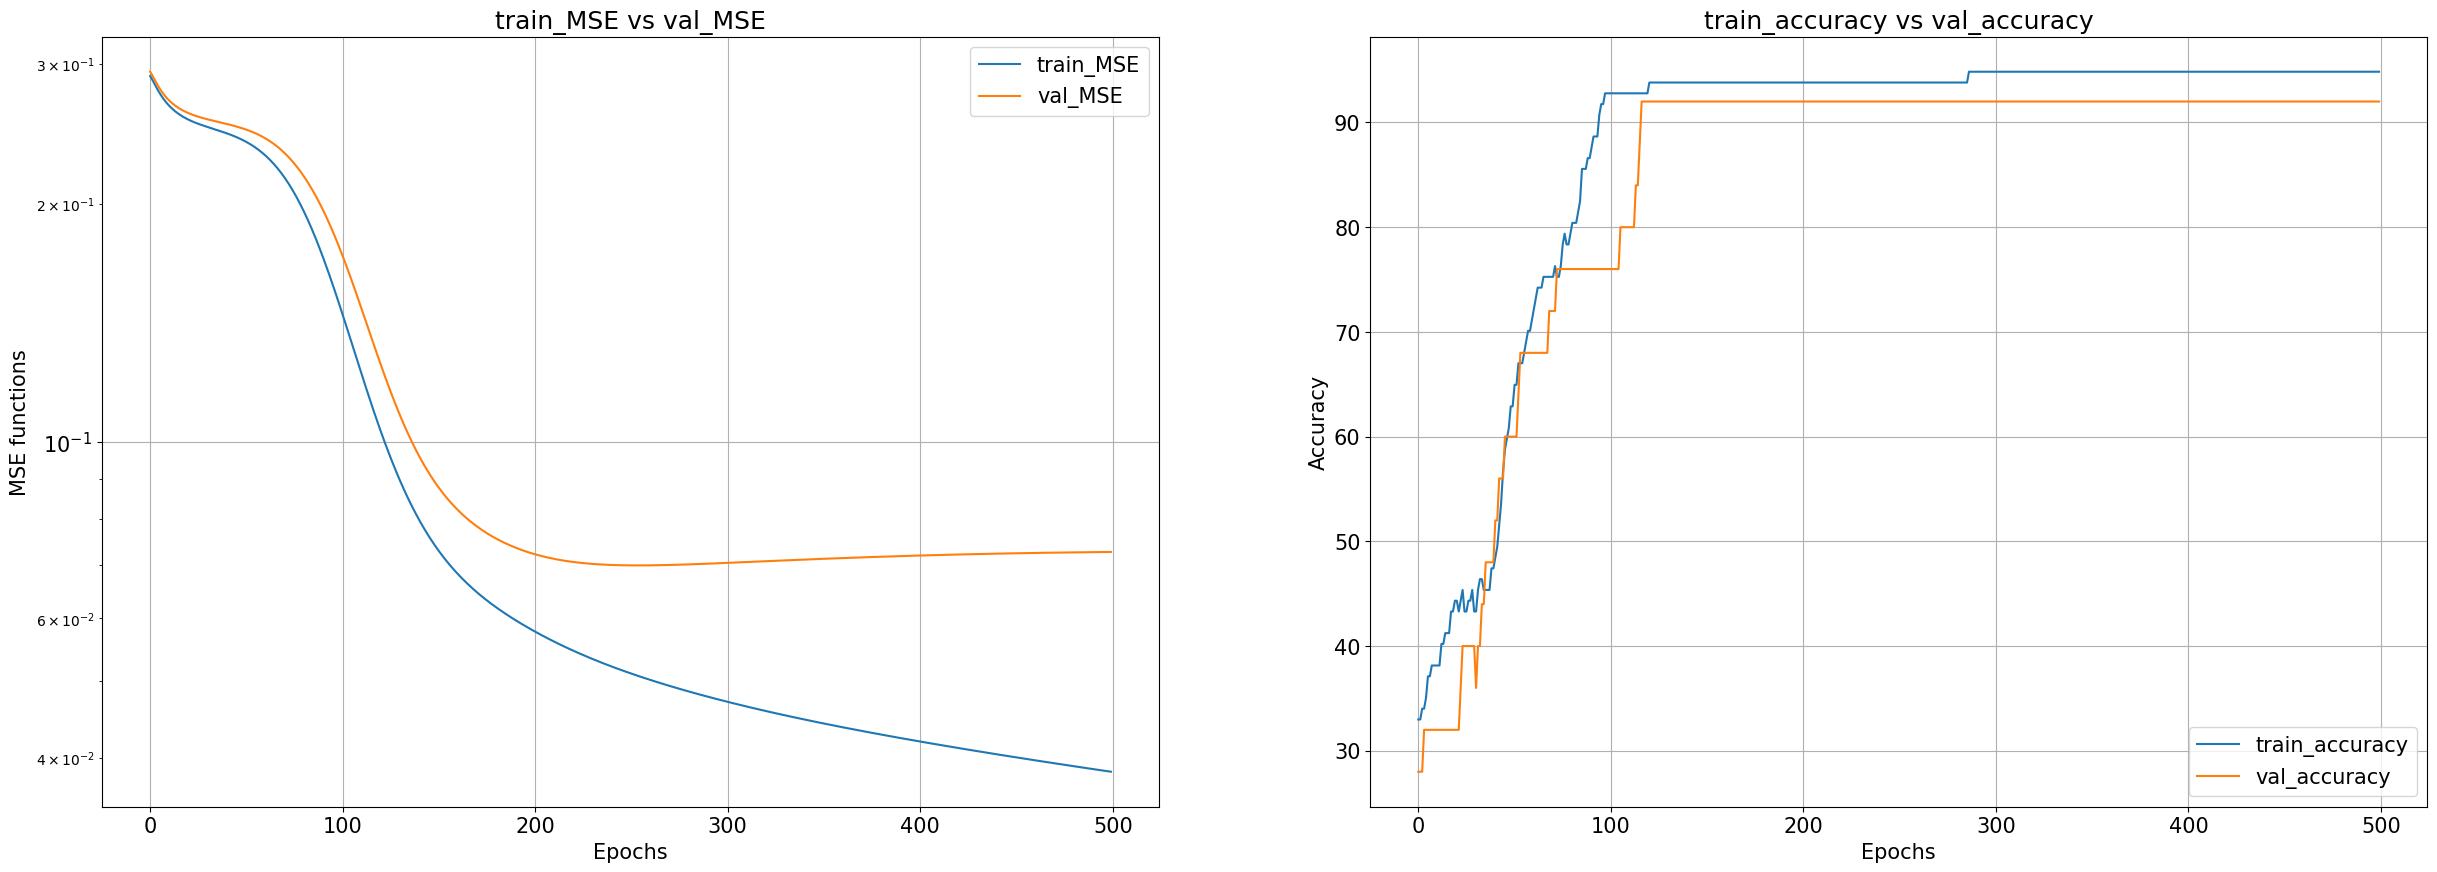

In [42]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_MSE'],label='train_MSE')
plt.plot(history_l2['val_MSE'], label='val_MSE')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs val_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_accuracy'],label='train_accuracy')
plt.plot(history_l2['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs val_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### L1 regularization


Build model


In [43]:
params = orig_params.copy()
input_layer = Input(17)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
output_layer = Layer(hidden_layer, 1, 'sigm')

model = NeuralNetwork(input_layer, output_layer, loss = 'binary_crossentropy', metrics = [accuracy, MSE])

model.set_initial_weights(init_weights_list)
arr = model.get_initial_weights_list()

Training with L1 regularization:


In [44]:
np.random.seed(seed)
params['l1_reg'] = True
history_l1 = model.train(X_train_monk, y_train_monk.reshape((1,X_train_monk.shape[1])),
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None,
                                    **params
                                    )


Epoch 0: train_loss: 7.751e-01, val_loss: 7.822e-01; train_accuracy: 3.299e+01, val_accuracy: 2.800e+01  train_MSE: 2.897e-01, val_MSE: 2.933e-01  lr : 0.09
Epoch 1: train_loss: 7.691e-01, val_loss: 7.761e-01; train_accuracy: 3.299e+01, val_accuracy: 2.800e+01  train_MSE: 2.869e-01, val_MSE: 2.904e-01  lr : 0.09
Epoch 2: train_loss: 7.625e-01, val_loss: 7.696e-01; train_accuracy: 3.402e+01, val_accuracy: 2.800e+01  train_MSE: 2.838e-01, val_MSE: 2.873e-01  lr : 0.09
Epoch 3: train_loss: 7.561e-01, val_loss: 7.632e-01; train_accuracy: 3.402e+01, val_accuracy: 2.800e+01  train_MSE: 2.808e-01, val_MSE: 2.843e-01  lr : 0.09
Epoch 4: train_loss: 7.501e-01, val_loss: 7.572e-01; train_accuracy: 3.505e+01, val_accuracy: 3.200e+01  train_MSE: 2.779e-01, val_MSE: 2.814e-01  lr : 0.09
Epoch 5: train_loss: 7.445e-01, val_loss: 7.517e-01; train_accuracy: 3.711e+01, val_accuracy: 3.200e+01  train_MSE: 2.752e-01, val_MSE: 2.787e-01  lr : 0.09
Epoch 6: train_loss: 7.395e-01, val_loss: 7.467e-01; train

In [45]:
l1_weights = model.get_initial_weights_list()

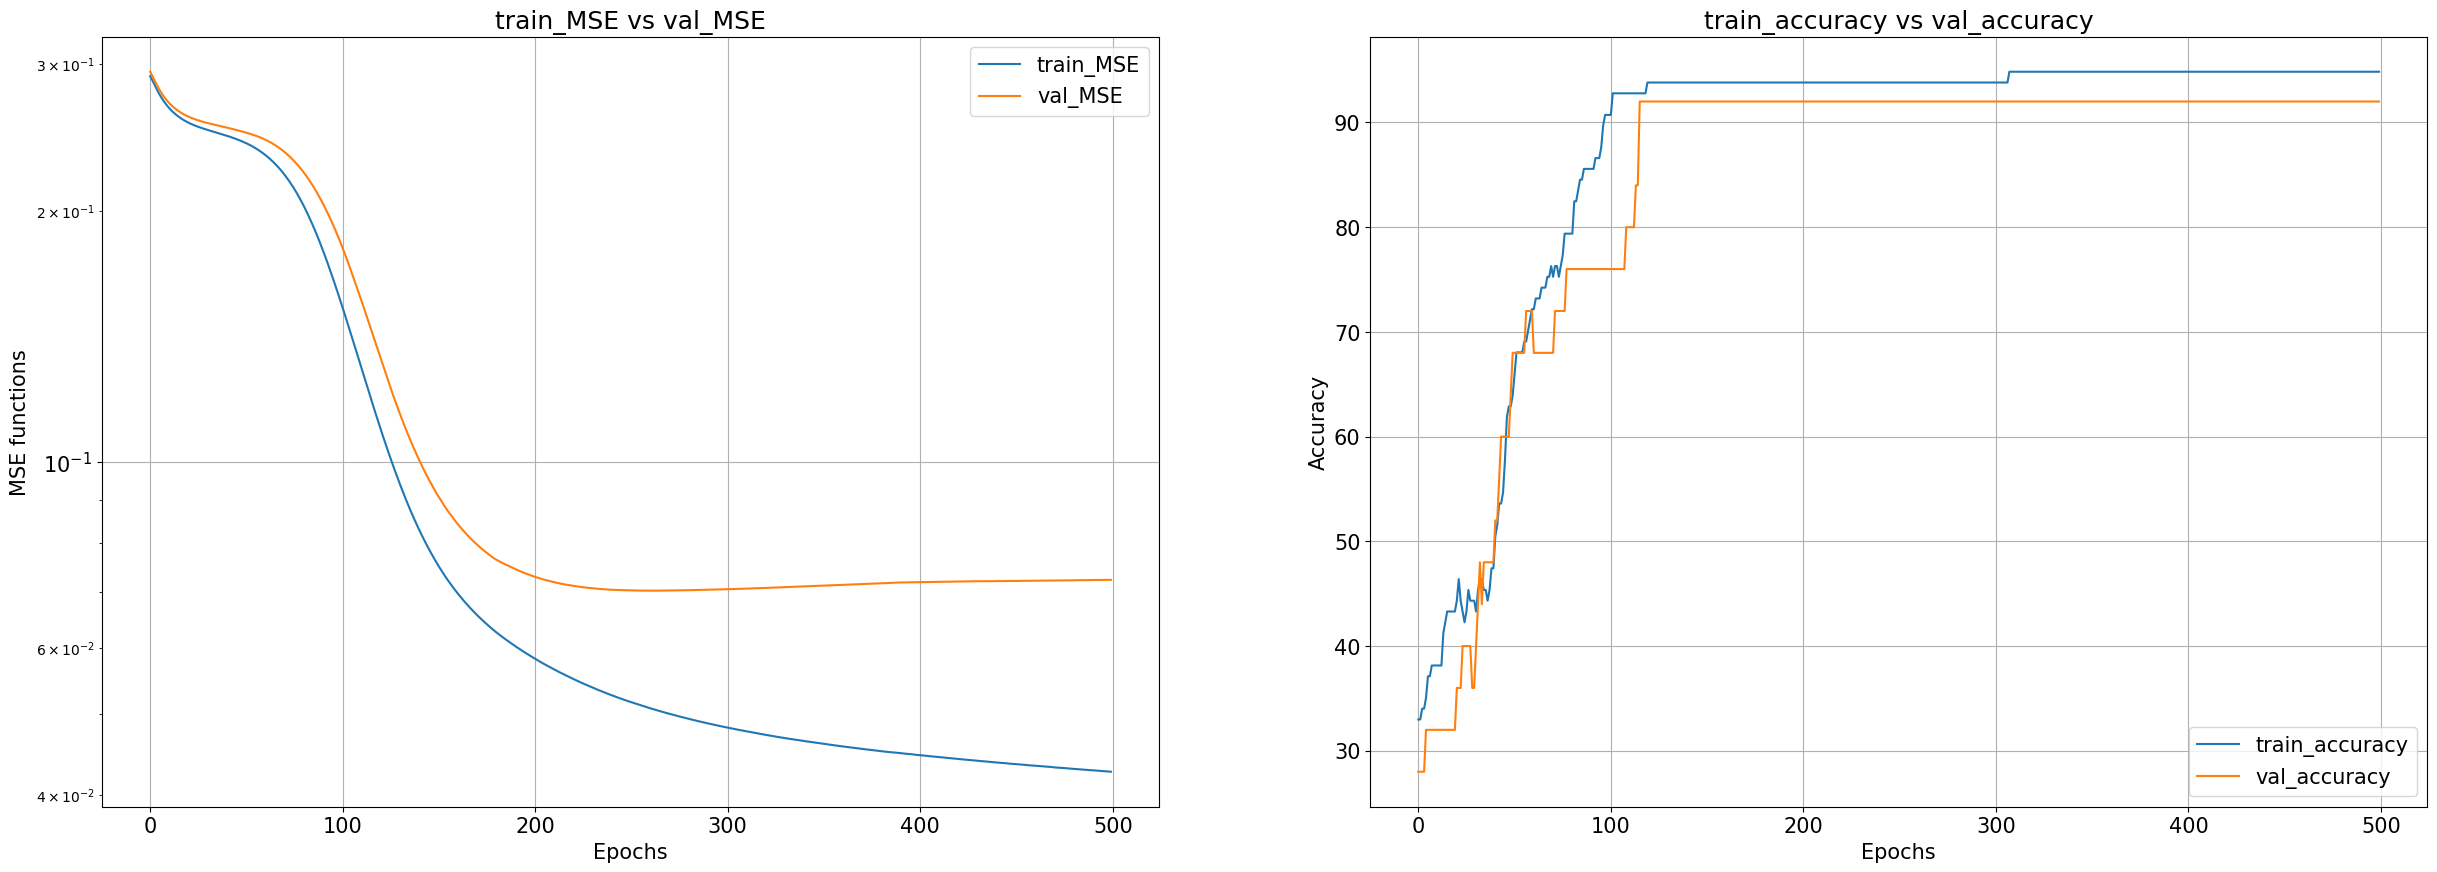

In [46]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l1['train_MSE'],label='train_MSE')
plt.plot(history_l1['val_MSE'], label='val_MSE')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs val_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l1['train_accuracy'],label='train_accuracy')
plt.plot(history_l1['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs val_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

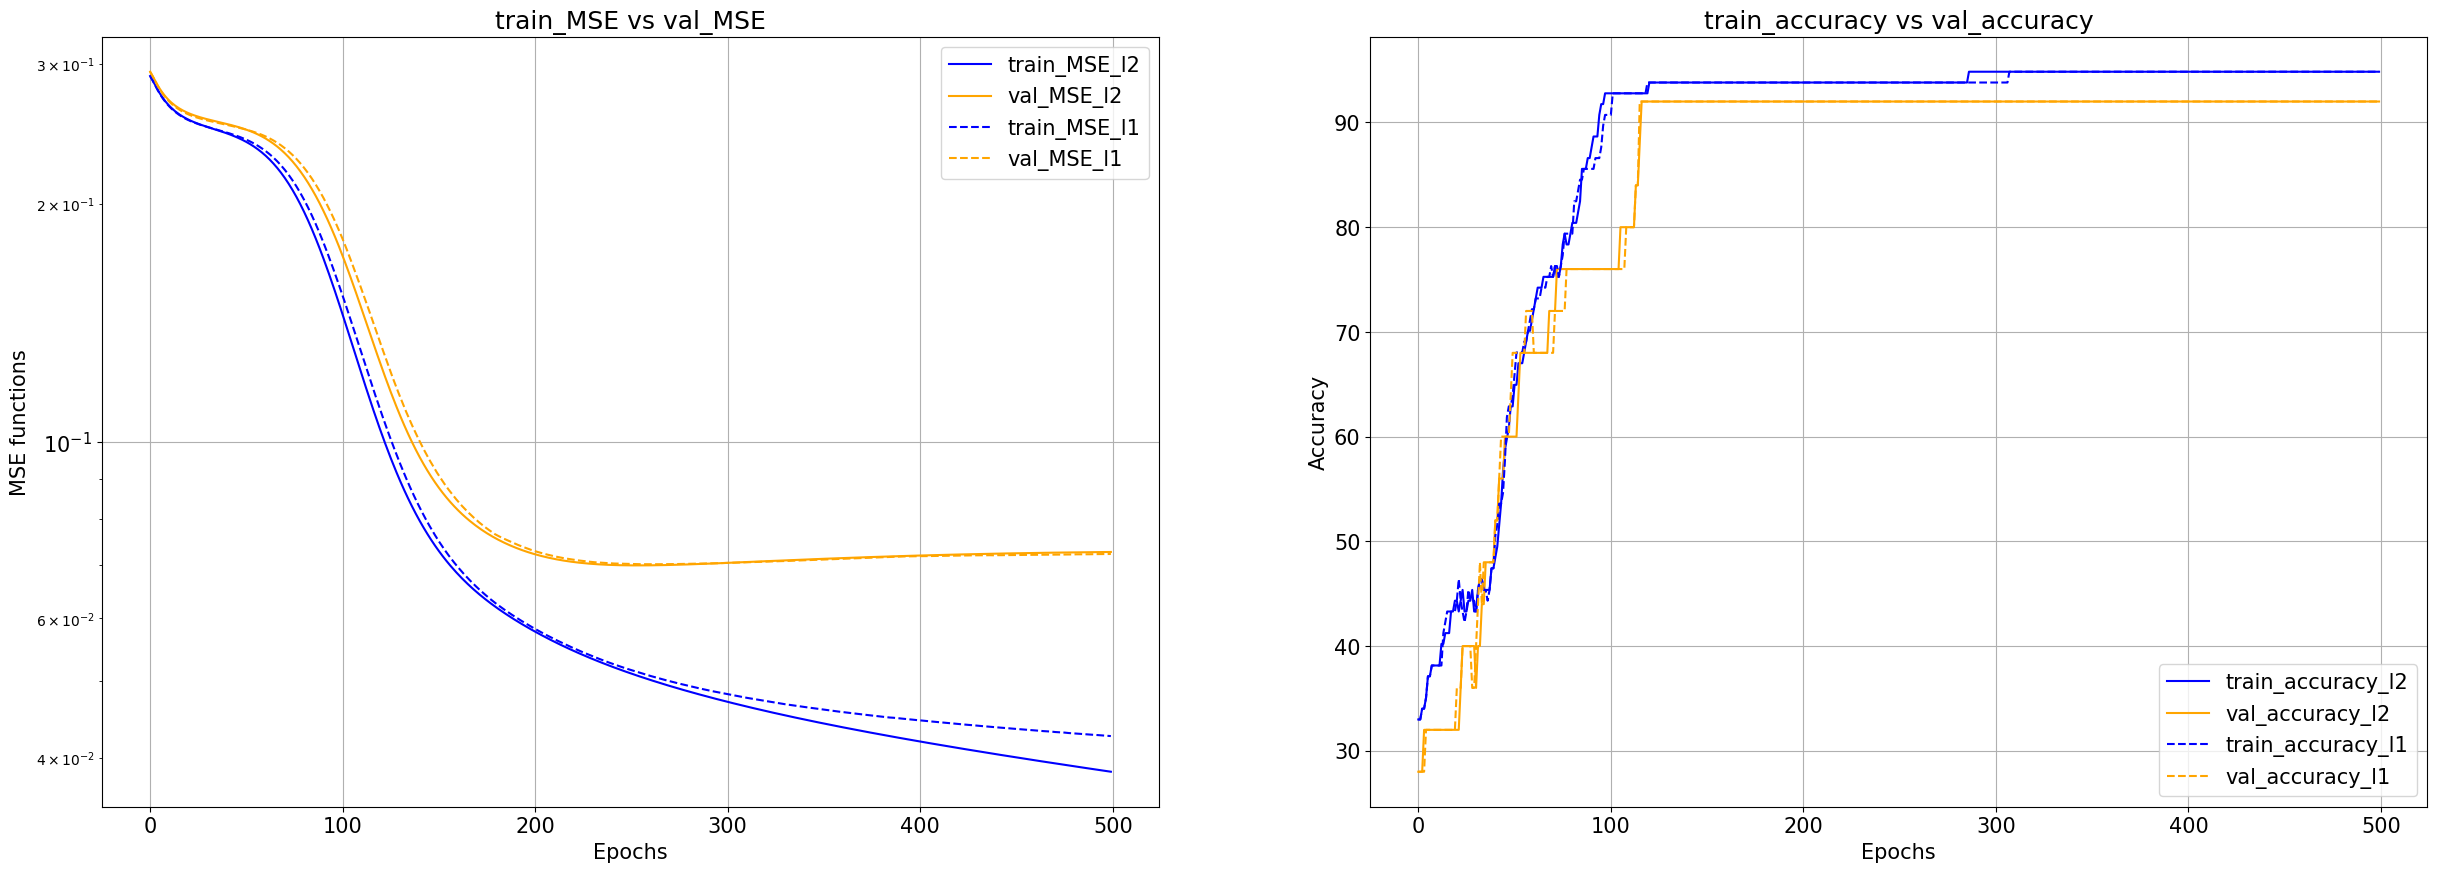

In [47]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_MSE'], '-', label='train_MSE_l2', color='blue')
plt.plot(history_l2['val_MSE'], '-', label='val_MSE_l2', color='orange')
plt.plot(history_l1['train_MSE'], '--', label='train_MSE_l1', color='blue')
plt.plot(history_l1['val_MSE'], '--', label='val_MSE_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MSE functions', size=15)
plt.title('train_MSE vs val_MSE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_accuracy'], '-',label='train_accuracy_l2', color='blue')
plt.plot(history_l2['val_accuracy'], '-', label='val_accuracy_l2', color='orange')
plt.plot(history_l1['train_accuracy'], '--', label='train_accuracy_l1', color='blue')
plt.plot(history_l1['val_accuracy'], '--', label='val_accuracy_l1', color='orange')
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.title('train_accuracy vs val_accuracy', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

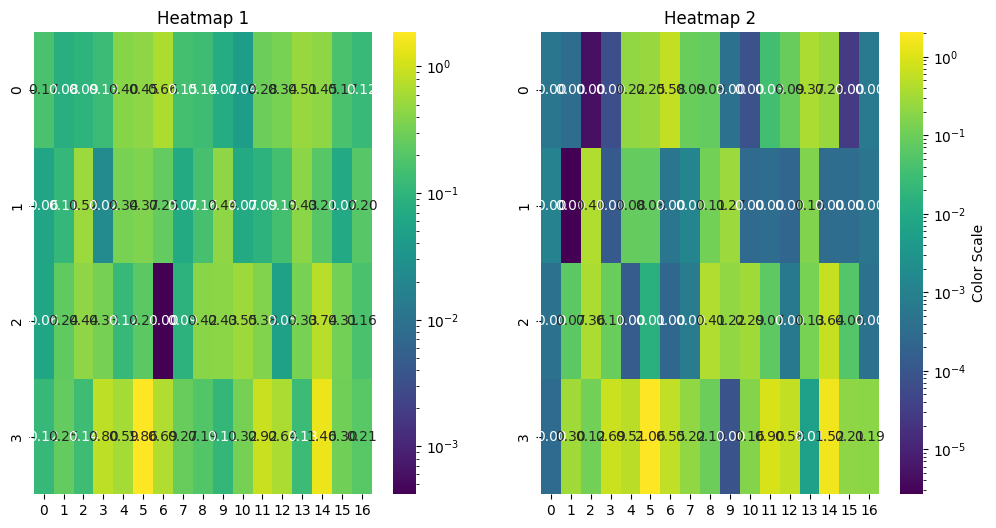

In [19]:
# Create two sample data matrices (replace these with your actual data)
data_matrix1 = np.abs(l2_weights[0][0])  # Replace with your data
data_matrix2 = np.abs(l1_weights[0][0])  # Replace with your data

# Find the minimum and maximum values across both data matrices
combined_min = min(np.min(data_matrix1), np.min(data_matrix2))
combined_max = max(np.max(data_matrix1), np.max(data_matrix2))

# Apply a logarithmic scale to the data (replace with your own scaling method)
#log_data1 = np.log1p(data_matrix1)
#log_data2 = np.log1p(data_matrix2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create heatmaps with the same color scale
heatmap1 = sn.heatmap(data_matrix1, annot=True, cmap="viridis", fmt=".2f", vmin=combined_min, vmax=combined_max, ax=axes[0], norm=LogNorm())
heatmap2 = sn.heatmap(data_matrix2, annot=True, cmap="viridis", fmt=".2f", vmin=combined_min, vmax=combined_max, ax=axes[1], norm=LogNorm())

# Set titles for the subplots
heatmap1.set_title('Heatmap 1')
heatmap2.set_title('Heatmap 2')

# Show the colorbar only for the second heatmap (optional)
cbar = heatmap2.collections[0].colorbar
cbar.set_label('Color Scale')

Text(158.22222222222223, 0.5, 'Layer units')

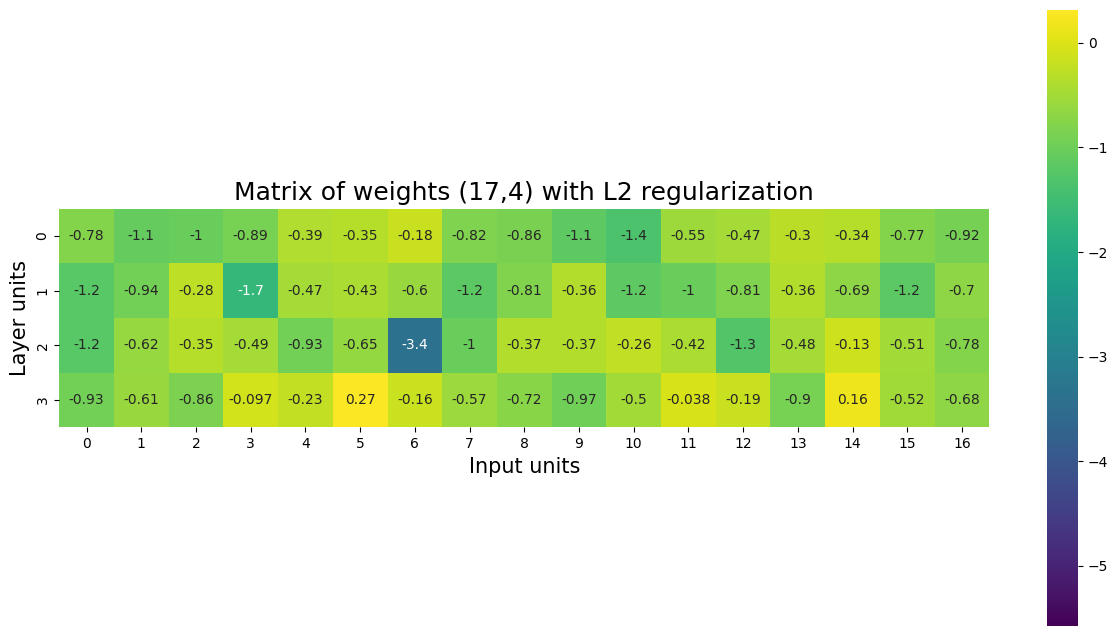

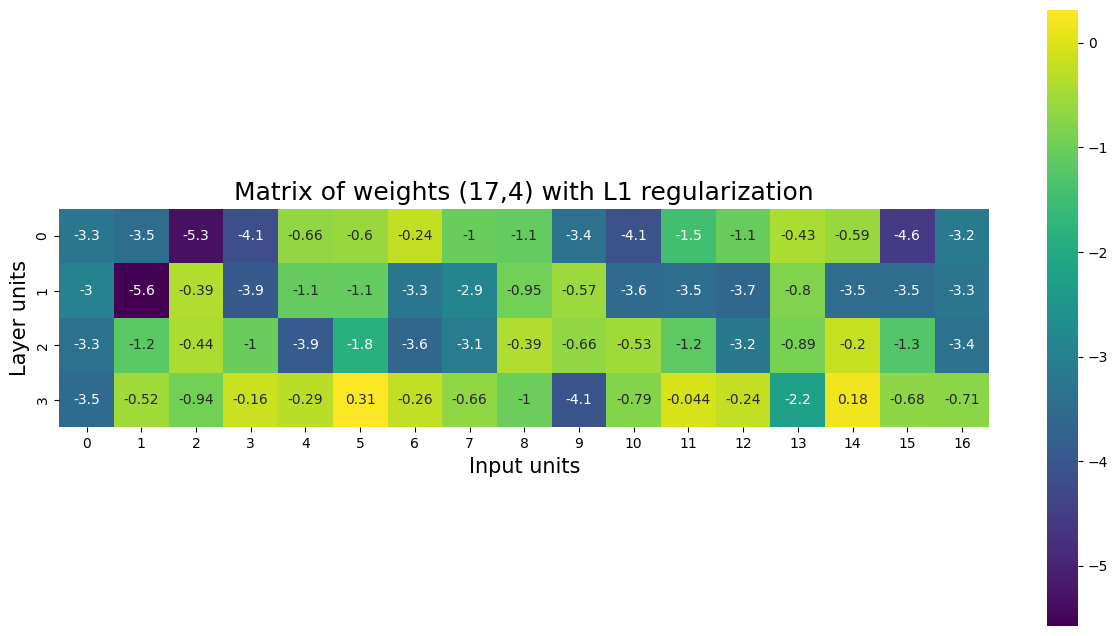

In [20]:
l2 = np.log10(np.abs(l2_weights[0][0]))
l1 = np.log10(np.abs(l1_weights[0][0]))

combined_min = min(np.min(l1), np.min(l2))
combined_max = max(np.max(l1), np.max(l2))

l2_norm = (l2 - np.min(l2)) / (np.max(l2) - np.min(l2))
l1_norm = (l1 - np.min(l1)) / (np.max(l1) - np.min(l1))

plt.figure(3,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L2 regularization',size=18)
sn.heatmap(l2, annot=True,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)
plt.figure(4,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L1 regularization',size=18)
sn.heatmap(l1, annot=True,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)

In [21]:
params = orig_params.copy()
params['loss'] = 'binary_crossentropy'
params['output_act_func'] = 'sigm'
params['scale_eta_batchsize'] = None
params['dim_hidden'] = params.pop('hidden_dim')
params['n_batch'] = 'batch'
print(params)
seed = np.random.randint(10,1000)
np.random.seed(seed)
params['l1_reg'] = False
history_cv_l2 = cross_validation(X_train_monk, y_train_monk.reshape(1,X_train_monk.shape[1]), folds=5, metrics=[MSE,accuracy], params=params.copy(), callbacks={'early_stopping':None, 'reduce_eta':None})
np.random.seed(seed)
params['l1_reg'] = True
history_cv_l1 = cross_validation(X_train_monk, y_train_monk.reshape(1,X_train_monk.shape[1]), 5, [MSE,accuracy], params=params.copy(), callbacks={'early_stopping':None, 'reduce_eta':None})

{'hidden_act_func': 'tanh', 'eta': 0.09, 'lam': 0.0004, 'alpha': 0.5, 'n_batch': 'batch', 'nest': False, 'l1_reg': False, 'epochs': 500, 'loss': 'binary_crossentropy', 'output_act_func': 'sigm', 'scale_eta_batchsize': None, 'dim_hidden': 4}


In [22]:
history_cv_l2

{'train_loss_mean': 0.1517378426987584,
 'train_loss_std': 0.021854473858714737,
 'val_loss_mean': 0.25352324627732786,
 'val_loss_std': 0.1041913446379672,
 'train_MSE_mean': 0.038820269285795996,
 'train_MSE_std': 0.005063281382874236,
 'val_MSE_mean': 0.0651675416317047,
 'val_MSE_std': 0.028053078421202783,
 'train_accuracy_mean': 94.06037414965985,
 'train_accuracy_std': 0.7417481474334296,
 'val_accuracy_mean': 92.62820512820511,
 'val_accuracy_std': 4.064324995935221}

In [23]:
history_cv_l1

{'train_loss_mean': 0.161989453482311,
 'train_loss_std': 0.025814940816542092,
 'val_loss_mean': 0.26172898944495293,
 'val_loss_std': 0.10251834335926409,
 'train_MSE_mean': 0.041996187987248856,
 'train_MSE_std': 0.0061553003790520665,
 'val_MSE_mean': 0.06573492943624173,
 'val_MSE_std': 0.02648220816274169,
 'train_accuracy_mean': 94.06037414965985,
 'train_accuracy_std': 0.7417481474334296,
 'val_accuracy_mean': 90.96153846153847,
 'val_accuracy_std': 3.1625375342420563}

<Axes: >

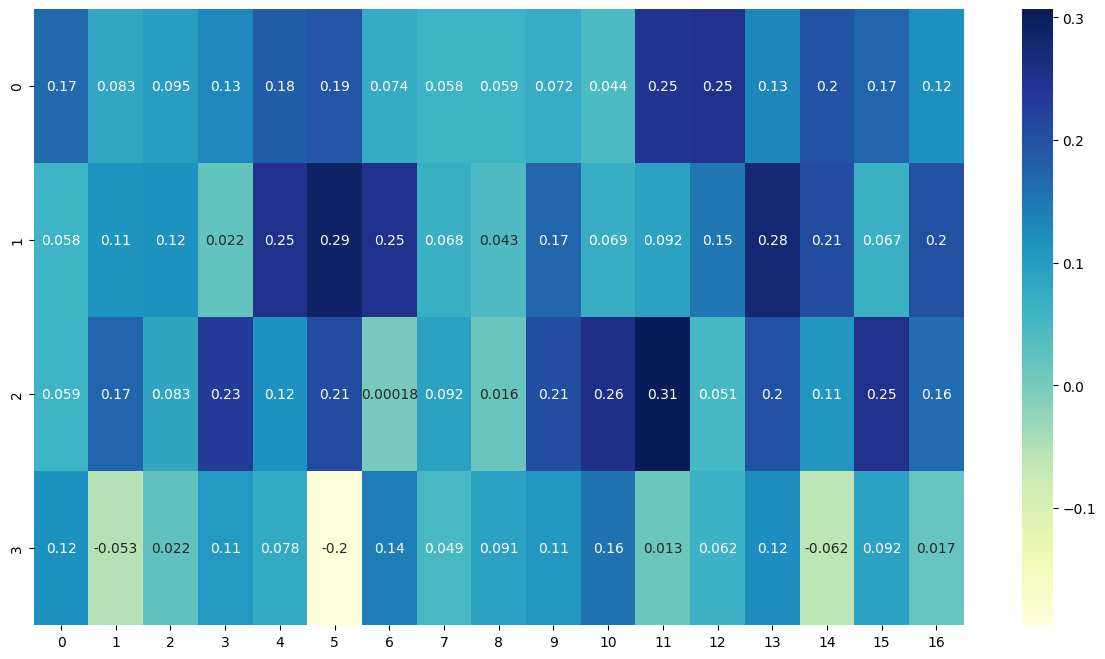

In [24]:
plt.figure(3,figsize=(15,8))

sn.heatmap(np.abs(l2_weights[0][0])-np.abs(l1_weights[0][0]), annot=True, cmap="YlGnBu")


## CUP

Define training and model hyperparameters

In [78]:
orig_params = {'hidden_dim': 30,
        'hidden_act_func': 'leaky_relu',
        'hidden_dim2': 30,
        'hidden_act_func2' : 'leaky_relu',
        'hidden_dim3': 30,
        'hidden_act_func3' : 'leaky_relu',
        'eta': 0.003,
        'lam': 0.05,
        'alpha': 0.06,
        'n_batch': 150,
        'use_opt':1,
        'nest': False,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }

### L2 regularization

Build model

In [79]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_initial_weights_list()

Training with L2 regularization:

In [80]:
np.random.seed(42)
params['l1_reg'] = False
history_l2 = model.train(X_train_cup, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 7.271e+02, val_loss: 7.204e+02; train_MEE: 4.212e+01, val_MEE: 4.161e+01  lr : 0.003
Epoch 1: train_loss: 6.770e+02, val_loss: 6.749e+02; train_MEE: 4.062e+01, val_MEE: 4.018e+01  lr : 0.003
Epoch 2: train_loss: 6.234e+02, val_loss: 6.263e+02; train_MEE: 3.895e+01, val_MEE: 3.865e+01  lr : 0.003
Epoch 3: train_loss: 5.641e+02, val_loss: 5.717e+02; train_MEE: 3.703e+01, val_MEE: 3.688e+01  lr : 0.003
Epoch 4: train_loss: 4.968e+02, val_loss: 5.091e+02; train_MEE: 3.470e+01, val_MEE: 3.475e+01  lr : 0.003
Epoch 5: train_loss: 4.232e+02, val_loss: 4.401e+02; train_MEE: 3.186e+01, val_MEE: 3.220e+01  lr : 0.003
Epoch 6: train_loss: 3.486e+02, val_loss: 3.686e+02; train_MEE: 2.856e+01, val_MEE: 2.923e+01  lr : 0.003
Epoch 7: train_loss: 2.838e+02, val_loss: 2.995e+02; train_MEE: 2.524e+01, val_MEE: 2.591e+01  lr : 0.003
Epoch 8: train_loss: 2.302e+02, val_loss: 2.392e+02; train_MEE: 2.215e+01, val_MEE: 2.250e+01  lr : 0.003
Epoch 9: train_loss: 1.896e+02, val_loss: 1.92

In [81]:
l2_weights = model.get_initial_weights_list()

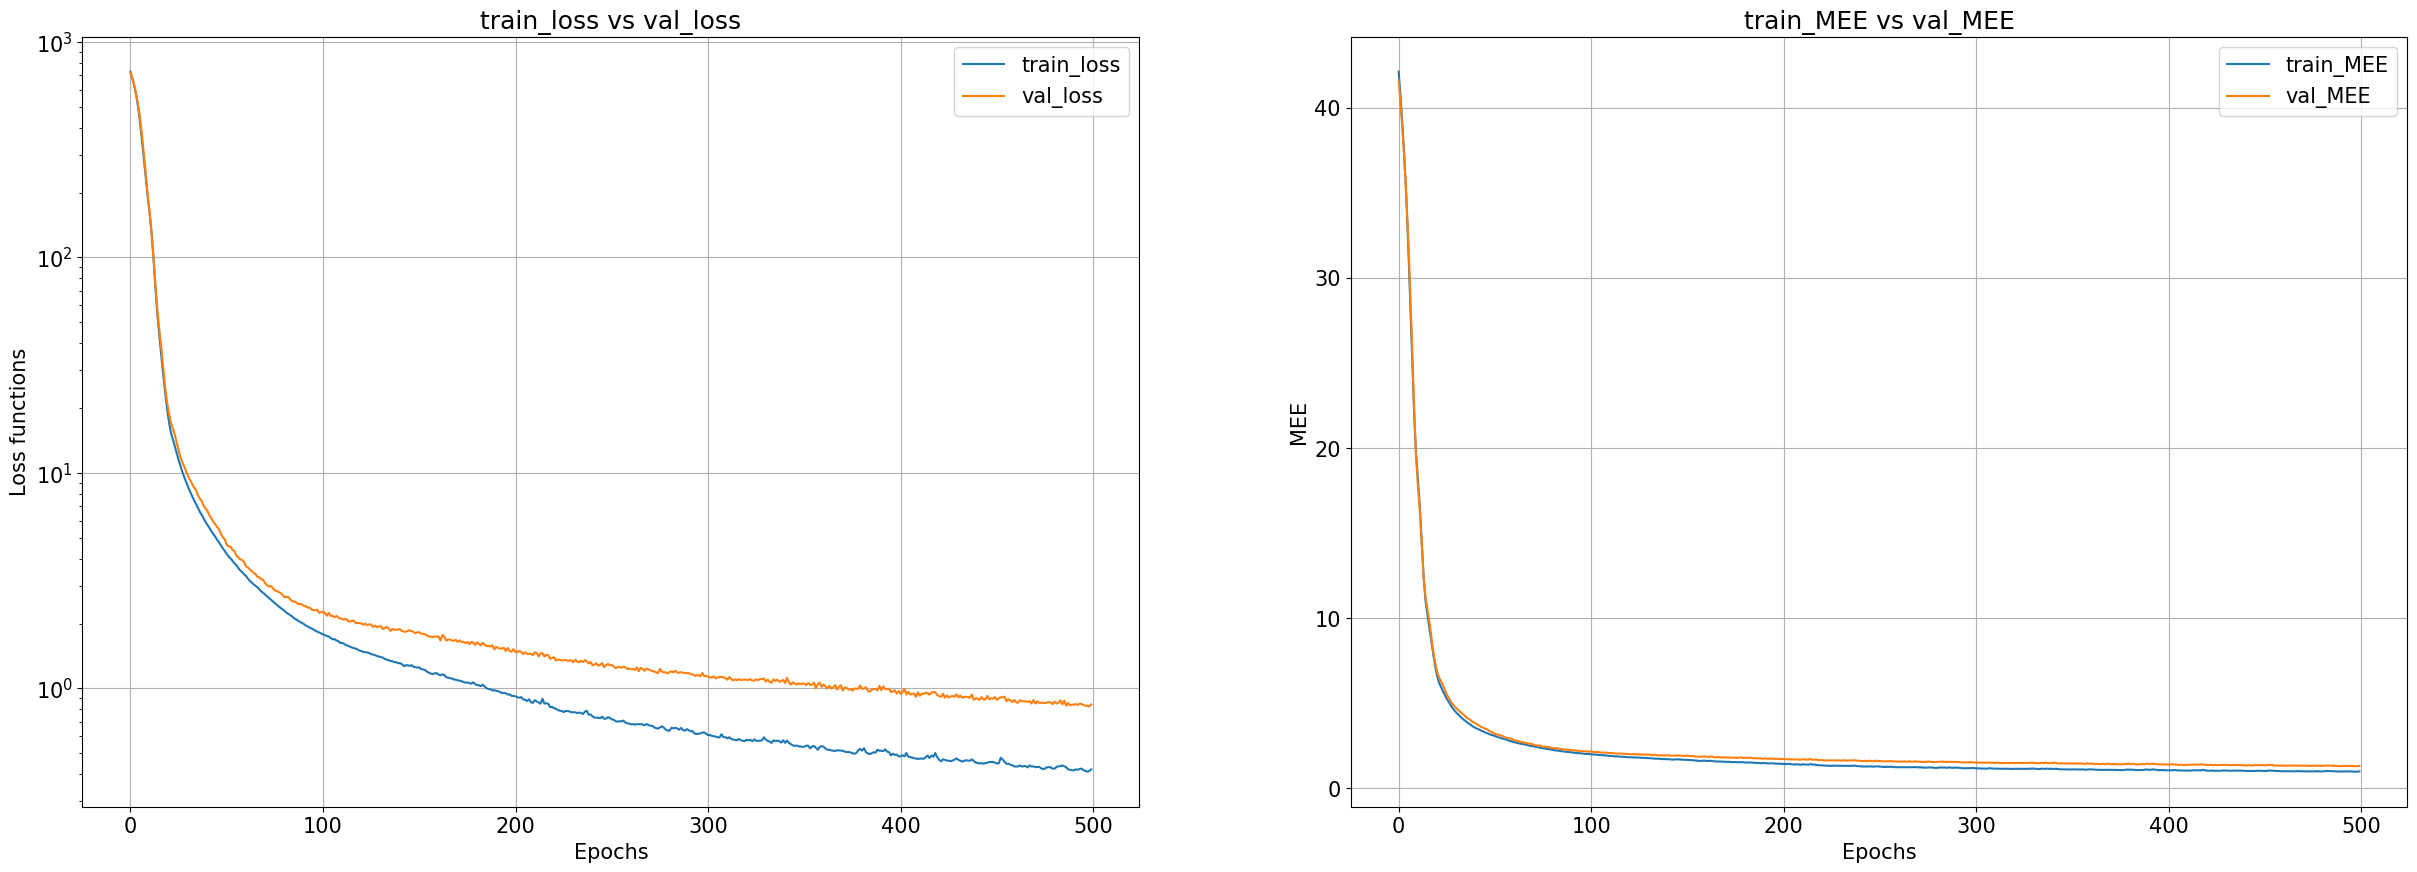

In [82]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_loss'],label='train_loss')
plt.plot(history_l2['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_MEE'],label='train_MEE')
plt.plot(history_l2['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### L1 regularization


Build model


In [83]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training with L1 regularization:


In [84]:
np.random.seed(42)
params['l1_reg'] = True
history_l1 = model.train(X_train_cup, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 7.272e+02, val_loss: 7.204e+02; train_MEE: 4.212e+01, val_MEE: 4.160e+01  lr : 0.003
Epoch 1: train_loss: 6.770e+02, val_loss: 6.749e+02; train_MEE: 4.062e+01, val_MEE: 4.018e+01  lr : 0.003
Epoch 2: train_loss: 6.235e+02, val_loss: 6.264e+02; train_MEE: 3.895e+01, val_MEE: 3.865e+01  lr : 0.003
Epoch 3: train_loss: 5.643e+02, val_loss: 5.719e+02; train_MEE: 3.704e+01, val_MEE: 3.689e+01  lr : 0.003
Epoch 4: train_loss: 4.971e+02, val_loss: 5.093e+02; train_MEE: 3.471e+01, val_MEE: 3.476e+01  lr : 0.003
Epoch 5: train_loss: 4.236e+02, val_loss: 4.404e+02; train_MEE: 3.188e+01, val_MEE: 3.222e+01  lr : 0.003
Epoch 6: train_loss: 3.496e+02, val_loss: 3.694e+02; train_MEE: 2.863e+01, val_MEE: 2.928e+01  lr : 0.003
Epoch 7: train_loss: 2.857e+02, val_loss: 3.016e+02; train_MEE: 2.539e+01, val_MEE: 2.606e+01  lr : 0.003
Epoch 8: train_loss: 2.326e+02, val_loss: 2.419e+02; train_MEE: 2.239e+01, val_MEE: 2.277e+01  lr : 0.003
Epoch 9: train_loss: 1.913e+02, val_loss: 1.94

In [85]:
l1_weights = model.get_initial_weights_list()

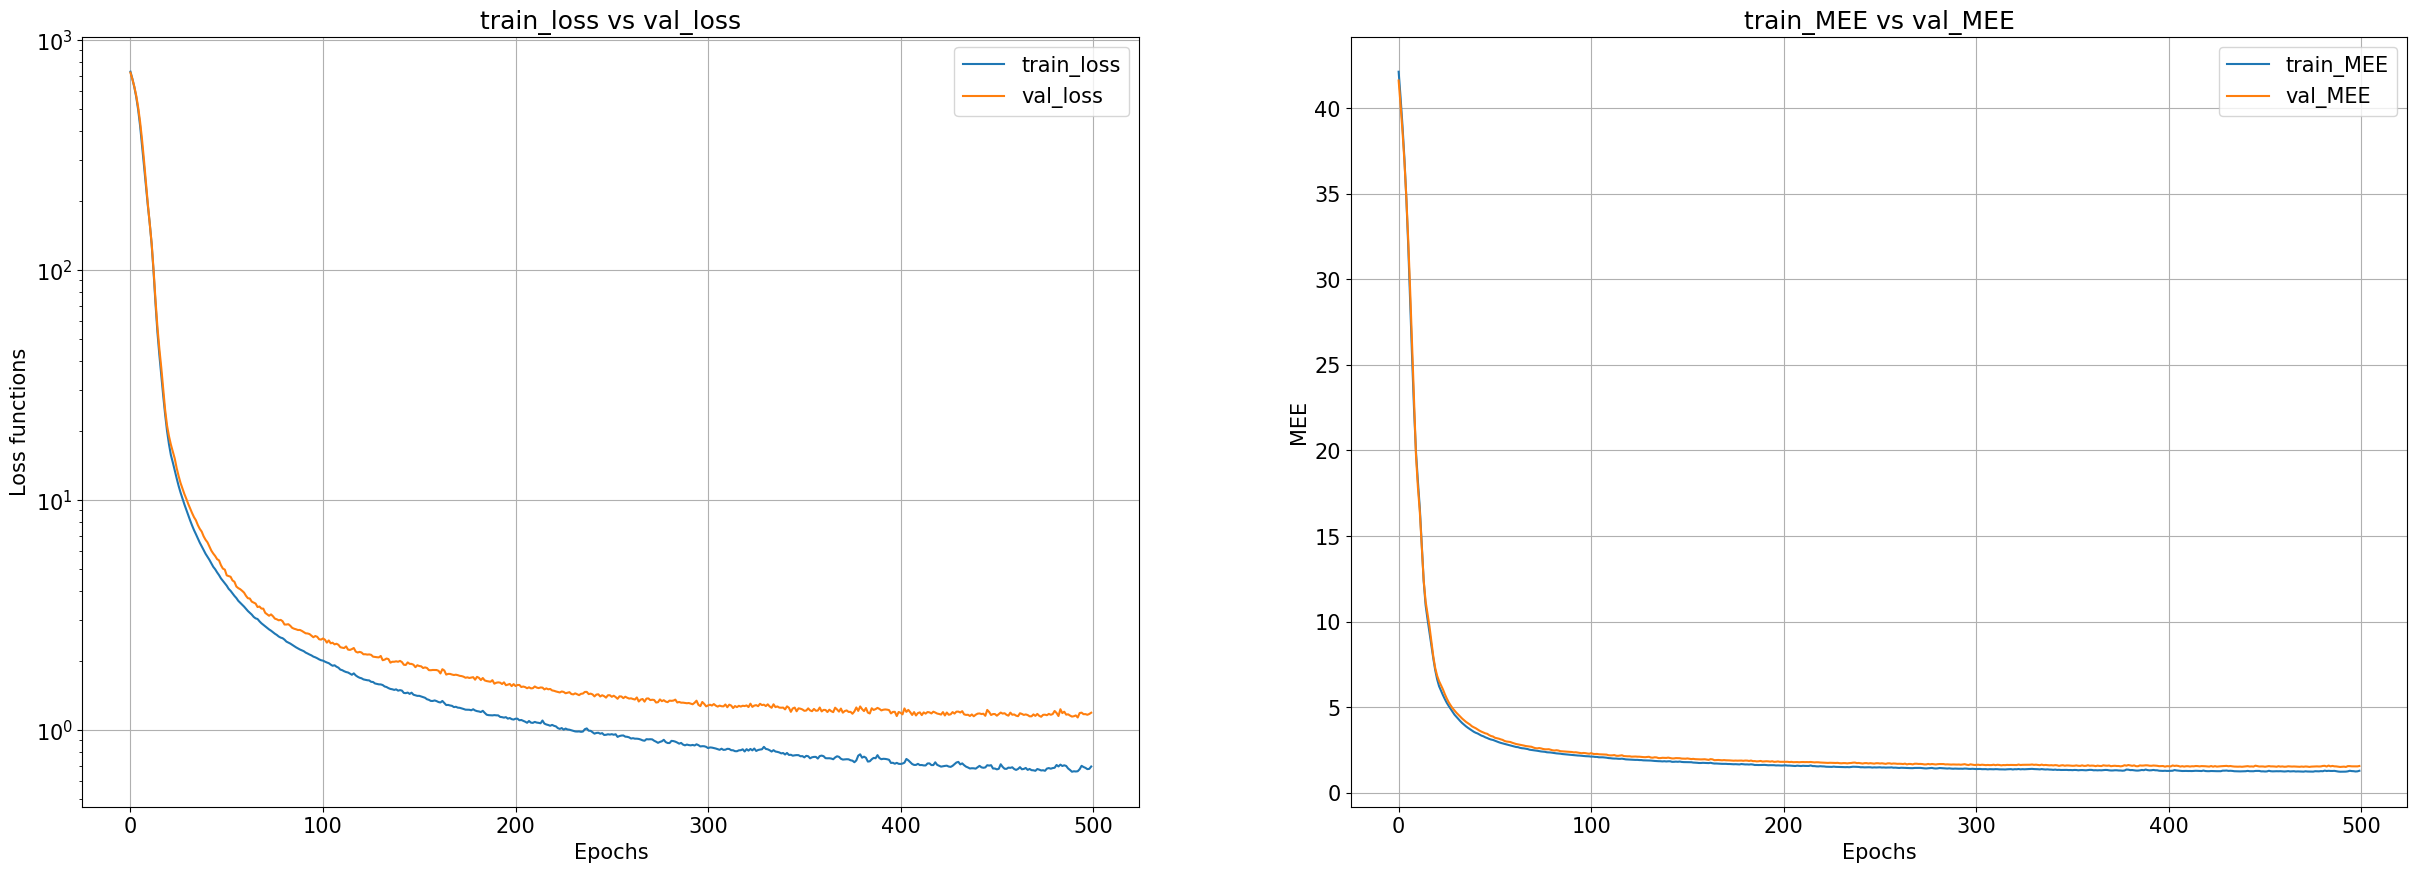

In [86]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l1['train_loss'],label='train_loss')
plt.plot(history_l1['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l1['train_MEE'],label='train_MEE')
plt.plot(history_l1['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

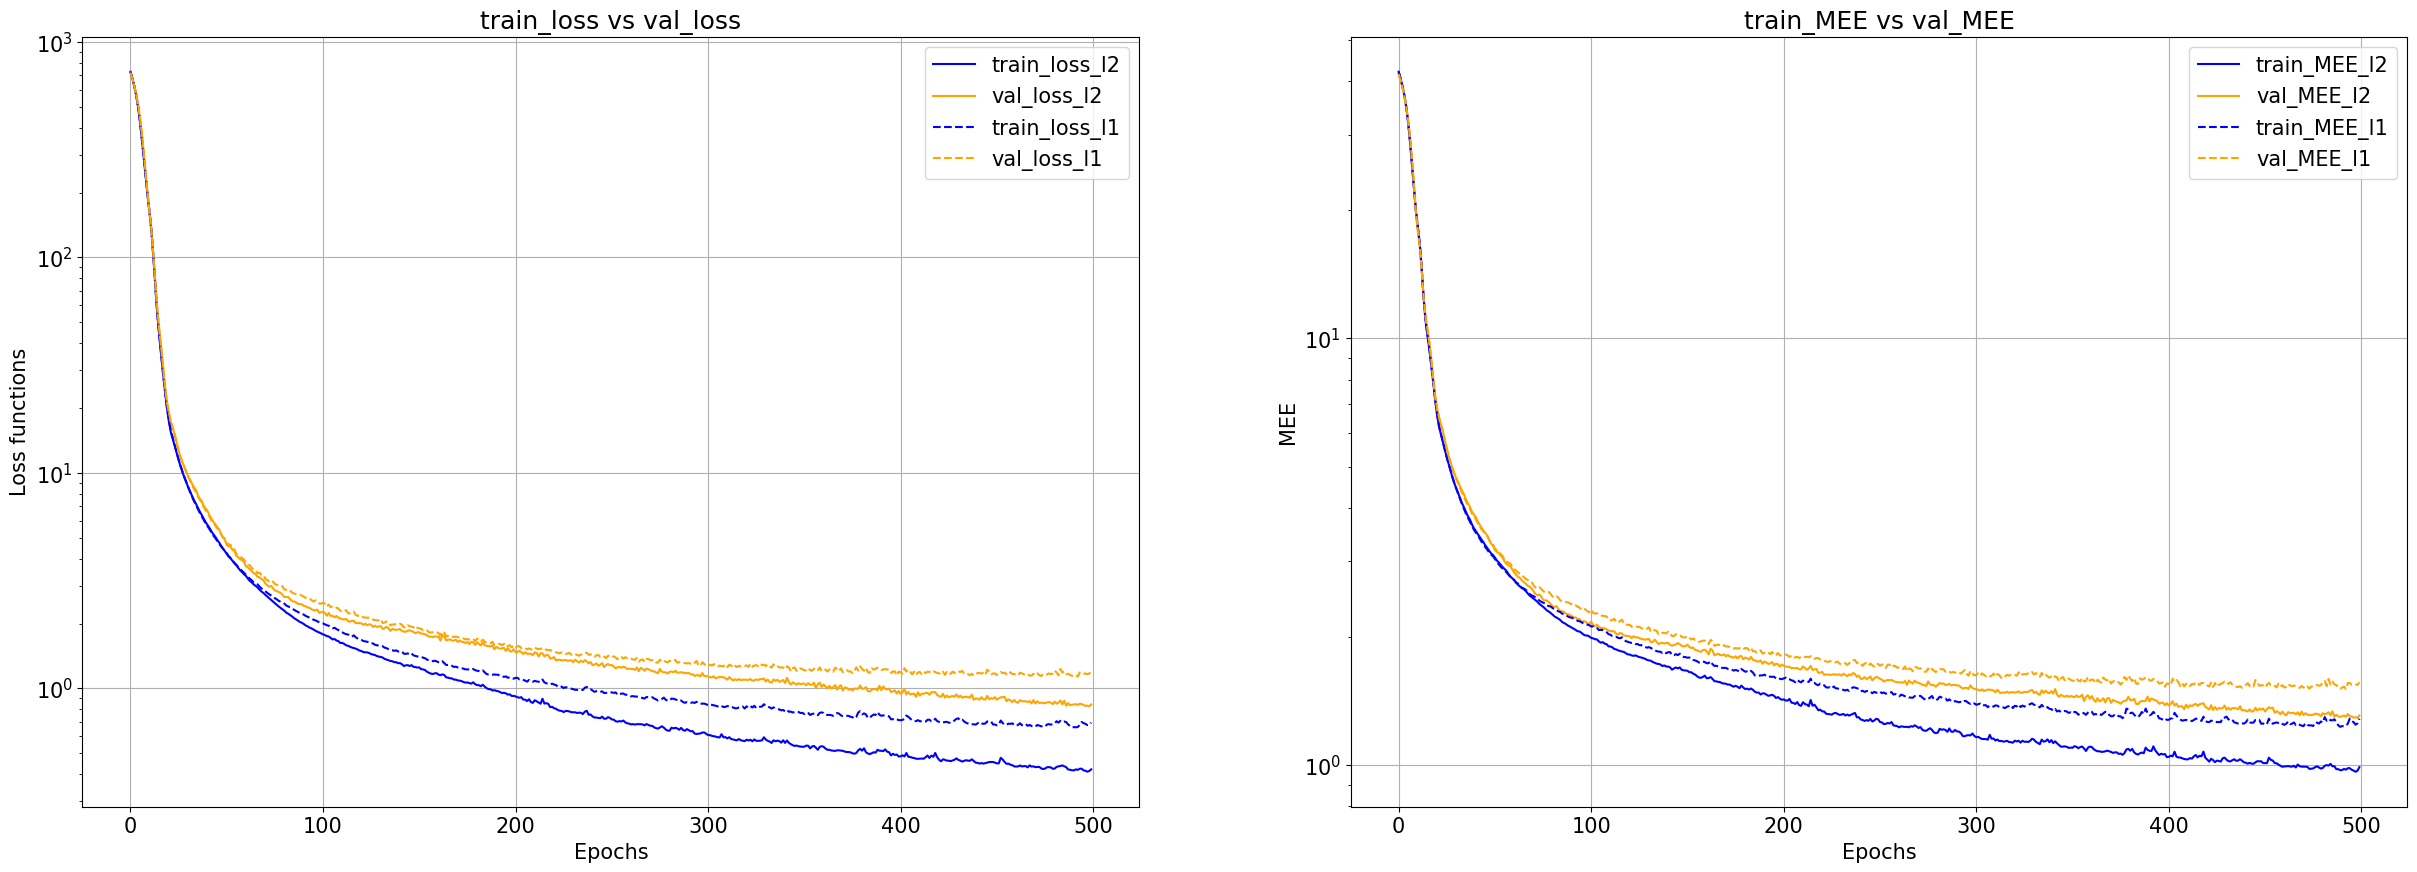

In [87]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_l2['train_loss'], '-', label='train_loss_l2', color='blue')
plt.plot(history_l2['val_loss'], '-', label='val_loss_l2', color='orange')
plt.plot(history_l1['train_loss'], '--', label='train_loss_l1', color='blue')
plt.plot(history_l1['val_loss'], '--', label='val_loss_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_l2['train_MEE'], '-',label='train_MEE_l2', color='blue')
plt.plot(history_l2['val_MEE'], '-', label='val_MEE_l2', color='orange')
plt.plot(history_l1['train_MEE'], '--', label='train_MEE_l1', color='blue')
plt.plot(history_l1['val_MEE'], '--', label='val_MEE_l1', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

Text(472.2222222222223, 0.5, 'Layer units')

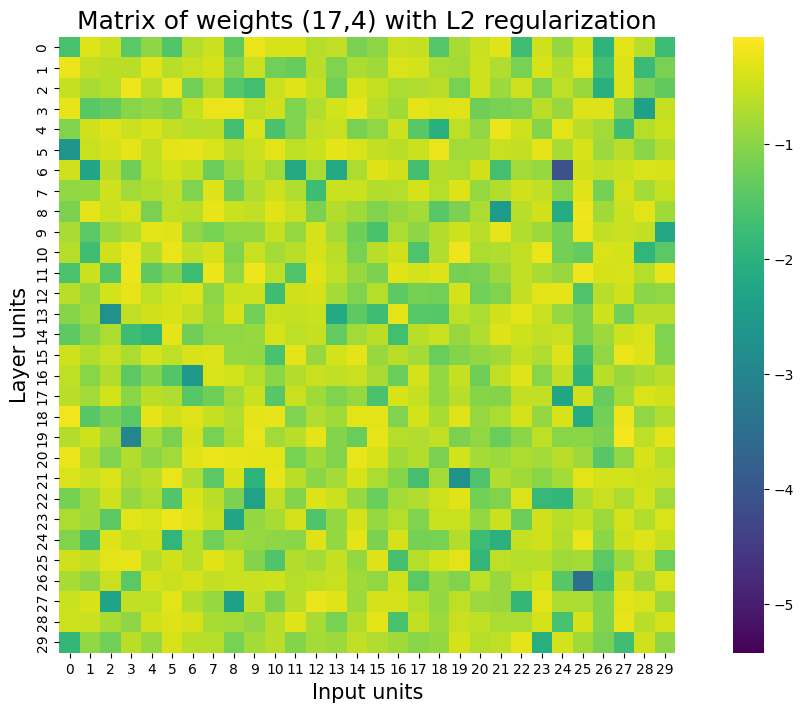

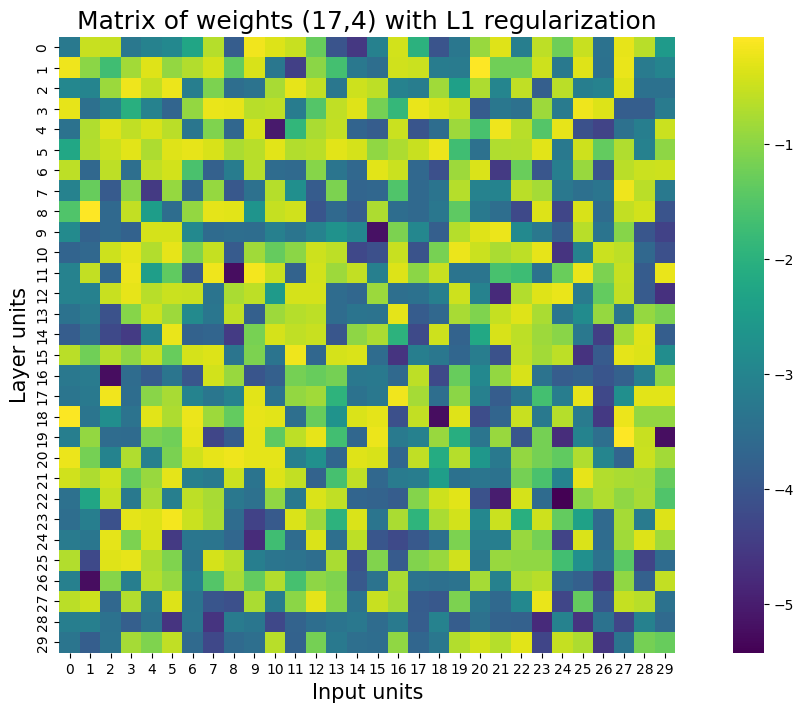

In [90]:
l2 = np.log10(np.abs(l2_weights[1][0]))
l1 = np.log10(np.abs(l1_weights[1][0]))

combined_min = min(np.min(l1), np.min(l2))
combined_max = max(np.max(l1), np.max(l2))

l2_norm = (l2 - np.min(l2)) / (np.max(l2) - np.min(l2))
l1_norm = (l1 - np.min(l1)) / (np.max(l1) - np.min(l1))

plt.figure(3,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L2 regularization',size=18)
sn.heatmap(l2, annot=False,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)
plt.figure(4,figsize=(15,8))
plt.title('Matrix of weights (17,4) with L1 regularization',size=18)
sn.heatmap(l1, annot=False,cmap='viridis',square=True,vmin=combined_min, vmax=combined_max)
plt.xlabel('Input units', size=15)
plt.ylabel('Layer units', size=15)